In [ ]:
import os

print("installing casa...")
os.system("pip install casatools==6.5.5.21")
os.system("pip install casatasks==6.5.5.21")
os.system("pip install casadata")
print("complete")

print("downloading MeasurementSet from CASA's test data repository")
os.system("wget https://open-bitbucket.nrao.edu/projects/CASA/repos/casatestdata/browse/measurementset/vla/sim_data_VLA_jet.ms")

import pylab as pl
import numpy as np
from casatasks import tclean

# Example generation of convergence plots

## Run tclean and save the return dictionary to disk. 

In [ ]:
%run -i Display_Experiments_Script.py
os.system('rm -rf try_cube_hogbom.*')
rec = tclean(vis='sim_data_VLA_jet.ms',imagename='try_cube_hogbom',imsize=512,cell='12.0arcsec',
       specmode='cube',interpolation='nearest',nchan=5,start='1.0GHz',width='0.2GHz',
       pblimit=-1e-05,deconvolver='hogbom',niter=10000, gain=0.2, 
             interactive=False,fullsummary=True,mask='circle[[256pix,256pix],150pix]')
np.save('try_cube_hogbom.summary.npy', rec) 


##  grep "iters=" casa-20230525-185528.log


2023-06-06 21:39:25	WARN	ImageRegridder::_doImagesOverlap	At least one of the images exceeds one degree on at one side, not checking for direction plane overlap.


## Read the return dictionary and make convergence plots.

In [ ]:
def PlotConvergence(recfile=''):
    
    summ = np.load(recfile,allow_pickle='TRUE').item()

    #return (summ['summaryminor'])

    summ_minor = summ['summaryminor']

    pl.figure(figsize=(9,3))
    pl.clf()
    ax1 = pl.subplot(121)
    pl.title('Peak Residual')
    ax2 = pl.subplot(122)
    pl.title('Total Flux')

    for field in summ_minor.keys():
        for chan in summ_minor[field].keys():
            for pol in summ_minor[field][chan].keys():
                #print("Plot for field %d channel %d and stokes %d"%(field,chan,pol))
                rec1 = summ_minor[field][chan][pol]
        
                iters=[] 
                peakres=[] 
                modflux=[] 
                
                start_iter=0
                for i in range(len(rec1['iterDone'])):  # Number of sets of minor cycles
                    iters.append(start_iter)                         # itercount at start
                    iters.append(start_iter + rec1['iterDone'][i])   # itercount at end
                    start_iter = start_iter + rec1['iterDone'][i]    # Update the starting point....
                    peakres.append(rec1['startPeakRes'][i])          # peakres at start
                    peakres.append(rec1['peakRes'][i])               # peakres at end
                    modflux.append(rec1['startModelFlux'][i])        # flux at start
                    modflux.append(rec1['modelFlux'][i])             # flux at end
            
                ax1.plot(iters, peakres,'r.-')
                ax2.plot(iters, modflux,'b.-')

    return summ_minor

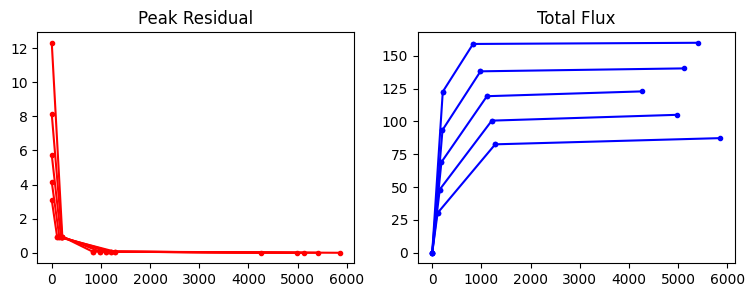

In [ ]:
PlotConvergence('try_cube_hogbom.summary.npy');

## More details : Extracting the iteration summary information

In [ ]:
summ = np.load('try_cube_hogbom.summary.npy',allow_pickle='TRUE').item()
summ_minor = summ['summaryminor']
summ_major = summ['summarymajor']

In [ ]:
## Print iterDone, startIterDone for channel 0
print(summ_minor[0][0][0]['iterDone'])
print(summ_minor[0][0][0]['startIterDone'])

[215.0, 616.0, 4581.0]
[0.0, 873.0, 5419.0]


In [ ]:
# To obtain a continuous iteration count for channel 0
## Note : This will not include the starting iteration number of zero....
iters = summ_minor[0][0][0]['iterDone']
cum_iters=[iters[0]]
for i in range(1,len(iters)):
    cum_iters.append( iters[i]+cum_iters[i-1] )
print(cum_iters)

[215.0, 831.0, 5412.0]


In [ ]:
## Print mod flux for channel 0
print(summ_minor[0][0][0]['modelFlux'])
print(summ_minor[0][0][0]['startModelFlux'])

[122.6711196899414, 158.99839782714844, 159.89544677734375]
[0.0, 122.6711196899414, 158.99839782714844]


In [ ]:
## Major cycle iteration number.
## The gap between each pair of entries here, represents the sum of minor cycle iterations across all channels.
## It is the same as "startIterDone" for channel 0. 
print(summ_major)

[    0   873  5419 25642]


In [ ]:
## Show the cyclethreshold.
## Note : This value is constant across channels, but replicated in the dictionary, for each channel/stokes plane. 
print(summ_minor[0][0][0]['cycleThresh'])

[0.951763927936554, 0.07355625927448273, 0.005683832336217165]


### Convergence plot 1 : Show values at the end of minor cycle iterations
An overlay of plots across the channel and stokes axes. 

X-axis : Iteration count, starting at zero for each channel/stokes image plane. This is the total number of iterations completed for the channel. 

Y-axis : Peak Residual and Total Model Flux. These values are recorded at the end of each set of minor cycle iterations. This plot does not show the starting values of peakres and model flux at the start of minor cycle iterations.

Plot for channel 0 and stokes 0
Plot for channel 0 and stokes 1
Plot for channel 0 and stokes 2
Plot for channel 0 and stokes 3
Plot for channel 0 and stokes 4


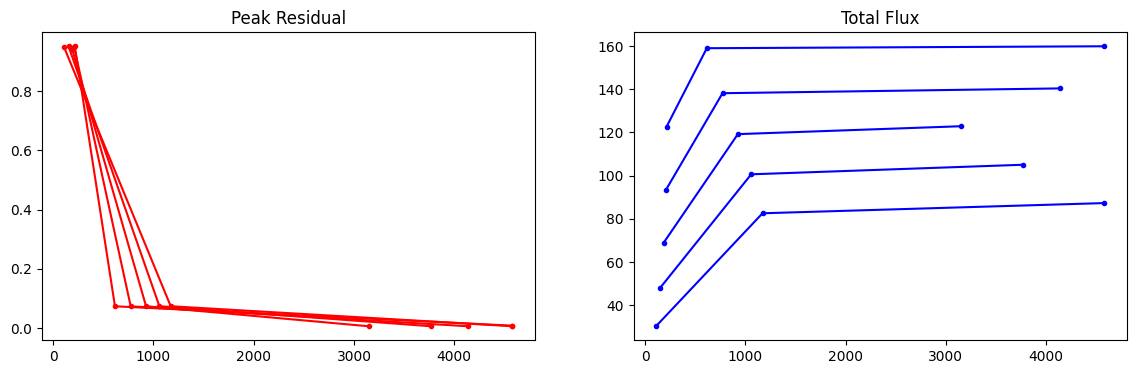

In [ ]:
chan=0
pol=0

pl.figure(figsize=(14,4))
pl.clf()
ax1 = pl.subplot(121)
pl.title('Peak Residual')
ax2 = pl.subplot(122)
pl.title('Total Flux')

for chan in summ_minor.keys():
    for pol in summ_minor[chan].keys():
        print("Plot for channel %d and stokes %d"%(chan,pol))
        rec1 = summ_minor[chan][pol][0]
        
        iters=rec1['iterDone']
        cum_iters=[iters[0]]
        for i in range(1,len(iters)):
            cum_iters.append( iters[i]+cum_iters[i-1] )

        peakres = rec1['peakRes']
        modflux = rec1['modelFlux']
        ax1.plot(iters, peakres,'r.-')
        ax2.plot(iters, modflux,'b.-')

The dots represent major cycle boundaries, per channel.

Note that the first set of points represent the values at the end of the first set of minor cycle iterations and the initial values are not displayed. So, if an initial startmode is supplied, it will not be reflected here. Further, this plot will not show the situation of the peak residual (say) stepping up across a major cycle boundary; something that can occur with over-fitting in the minor cycles. 

### Convergence Plot 2 : Values at the start and end of minor cycle iteration sets
The following is an example to create plots with both start and end values shown per minor-cycle set. This is useful to identify if there are jumps in peak residual across a major cycle boundary. 

Plot for field 0 channel 0 and stokes 0
Plot for field 0 channel 1 and stokes 0
Plot for field 0 channel 2 and stokes 0
Plot for field 0 channel 3 and stokes 0
Plot for field 0 channel 4 and stokes 0


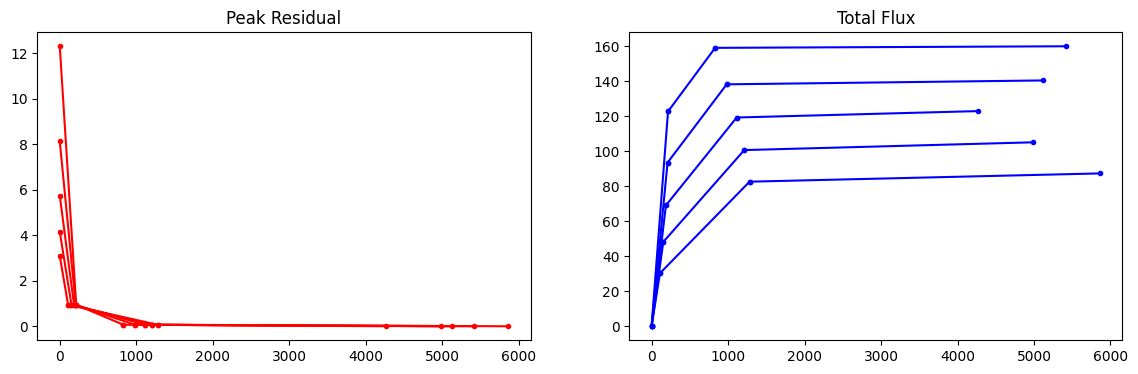

In [ ]:
chan=0
pol=0

pl.figure(figsize=(14,4))
pl.clf()
ax1 = pl.subplot(121)
pl.title('Peak Residual')
ax2 = pl.subplot(122)
pl.title('Total Flux')

for field in summ_minor.keys():
    for chan in summ_minor[field].keys():
        for pol in summ_minor[field][chan].keys():
            print("Plot for field %d channel %d and stokes %d"%(field,chan,pol))
            rec1 = summ_minor[field][chan][pol]

            ## Set the first element to the start
            iters=[] #rec1['startIterDone'][0]]
            peakres=[] #[rec1['startPeakRes'][0]]
            modflux=[] #[rec1['startModFlux'][0]]

            start_iter=0
            for i in range(len(rec1['iterDone'])):  ## Number of sets of minor cycles
                iters.append(start_iter)          # itercount at start
                iters.append(start_iter + rec1['iterDone'][i])   # itercount at end
                start_iter = start_iter + rec1['iterDone'][i]  # Update the starting point....
                peakres.append(rec1['startPeakRes'][i])  # peakres at start
                peakres.append(rec1['peakRes'][i])          # peakres at end
                modflux.append(rec1['startModelFlux'][i])  # flux at start
                modflux.append(rec1['modelFlux'][i])          # flux at end

            ax1.plot(iters, peakres,'r.-')
            ax2.plot(iters, modflux,'b.-')

In this plot, both the start and end values are displayed. In an ideal run, the value of at the end of a set of minot cycle iterations will be nearly identical to the value at the start of the next set of minor cycle iterations (i.e. no change across a major-cycle boundary).

If there is a jump in peak residual across the major cycle boundary, it will appear as a vertical line where there is currently a dot. 

The starting model total flux is also displayed now (in this case, it starts at zero). 

The iteration count is independent per channel. This address the use case of needing to compare channels against each other as it is clear exactly how many iterations have been done per channel.   This will not match the global iteration counters in the logger, which are cumulative across channels (the next plot uses the global iteration count). 


### Convergence plot 4 : Peak Res and Model Flux at major cycle boundaries
A plot where the major cycle boundary is synchronized across all channels. The iteration count from one major cycle to the next represents the sum of minor cycle iterations across all channels. 

This example is nearly identical to example 3 above, and differs only in its use of the major cycle iteration count on the x-axis, and the inclusion of 'cycleThreshold' in the plot. The iteration count on the x-axis is now cumulative across all channels (in the way 'niter' is currently counted in tclean for cube imaging). This xaxis will match the iteration counters shown in the log messages. 

Plot for field 0 channel 0 and stokes 0
Plot for field 0 channel 1 and stokes 0
Plot for field 0 channel 2 and stokes 0
Plot for field 0 channel 3 and stokes 0
Plot for field 0 channel 4 and stokes 0


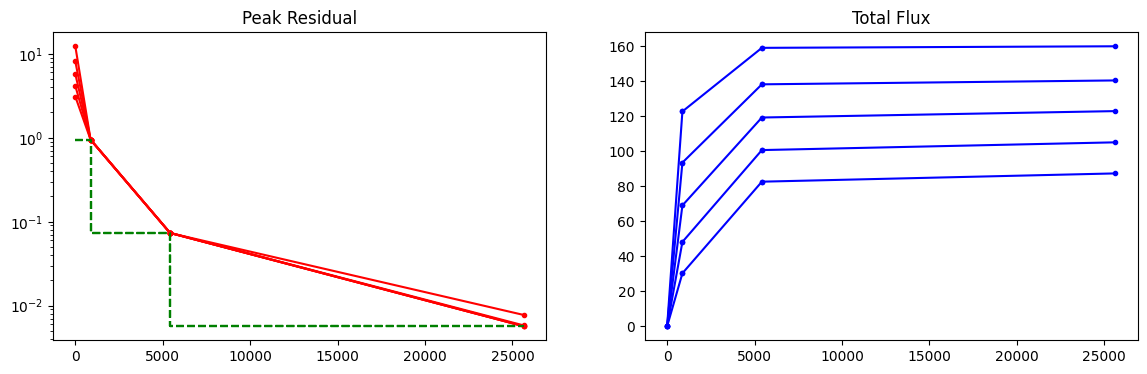

In [ ]:
chan=0
pol=0

pl.figure(figsize=(14,4))
pl.clf()
ax1 = pl.subplot(121)
pl.title('Peak Residual')
ax2 = pl.subplot(122)
pl.title('Total Flux')

for field in summ_minor.keys():
    for chan in summ_minor[field].keys():
        for pol in summ_minor[field][chan].keys():
            print("Plot for field %d channel %d and stokes %d"%(field,chan,pol))
            rec1 = summ_minor[field][chan][pol]
        

            ## Set the first element to the start
            iters=[] 
            peakres=[] 
            modflux=[] 
            cycthresh=[]

            start_iter=0
            for i in range(len(rec1['iterDone'])):  ## Number of sets of minor cycles
                iters.append(start_iter)          # itercount at start
                iters.append(summ_major[i+1])     # itercount at end
                start_iter = summ_major[i+1]  # Update the starting point....
                peakres.append(rec1['startPeakRes'][i])  # peakres at start
                peakres.append(rec1['peakRes'][i])          # peakres at end
                modflux.append(rec1['startModelFlux'][i])  # flux at start
                modflux.append(rec1['modelFlux'][i])          # flux at end
                cycthresh.append(rec1['cycleThresh'][i])    # cyclethreshold for this set of iters
                cycthresh.append(rec1['cycleThresh'][i])    # cyclethreshold for this set of iters

            ax1.semilogy(iters, peakres,'r.-')
            ax1.semilogy(iters,cycthresh, 'g--')

            ax2.plot(iters, modflux,'b.-')


Plots for all channels are synchronized at major-cycle boundaries. With this kind of plot, one can check/see the effect of the cyclethreshold parameter as it is the same value for all channels.


## Convergence plot 5 : True iteration count on the x axis.....

Plot for field 0 channel 0 and stokes 0
Plot for field 0 channel 1 and stokes 0
Plot for field 0 channel 2 and stokes 0
Plot for field 0 channel 3 and stokes 0
Plot for field 0 channel 4 and stokes 0


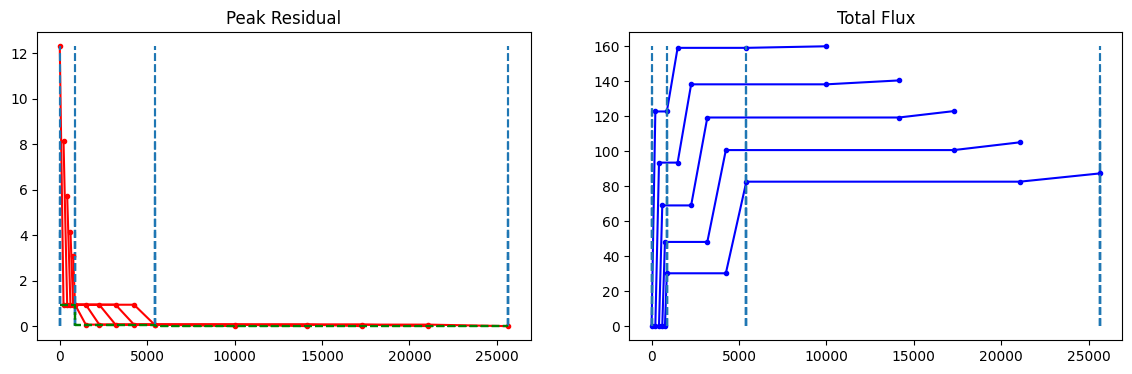

In [ ]:
chan=0
pol=0

pl.figure(figsize=(14,4))
pl.clf()
ax1 = pl.subplot(121)
pl.title('Peak Residual')
ax2 = pl.subplot(122)
pl.title('Total Flux')

for field in summ_minor.keys():
    for chan in summ_minor[field].keys():
        for pol in summ_minor[field][chan].keys():
            print("Plot for field %d channel %d and stokes %d"%(field,chan,pol))
            rec1 = summ_minor[field][chan][pol]

            ## Set the first element to the start
            iters=[] 
            peakres=[] 
            modflux=[] 

            for i in range(len(rec1['iterDone'])):  ## Number of sets of minor cycles
                iters.append(rec1['startIterDone'][i])          # itercount at start
                iters.append(rec1['startIterDone'][i] + rec1['iterDone'][i] )     # itercount at end
                peakres.append(rec1['startPeakRes'][i])  # peakres at start
                peakres.append(rec1['peakRes'][i])          # peakres at end
                modflux.append(rec1['startModelFlux'][i])  # flux at start
                modflux.append(rec1['modelFlux'][i])          # flux at end


            maj_iter=[]
            cycthresh=[]
            start_iter=0
            for i in range(len(rec1['iterDone'])):  ## Number of sets of minor cycles
                maj_iter.append(start_iter)          # itercount at start
                maj_iter.append(summ_major[i+1])     # itercount at end
                start_iter = summ_major[i+1]  # Update the starting point....
                cycthresh.append(rec1['cycleThresh'][i])    # cyclethreshold for this set of iters
                cycthresh.append(rec1['cycleThresh'][i])    # cyclethreshold for this set of iters


            ax1.plot(iters, peakres,'r.-')
            ax2.plot(iters, modflux,'b.-')

            #Vertical lines for major cycle boundaries
            for it in summ_major:
                ax1.vlines(x=[it,it], ymin=0, ymax=np.max(peakres),linestyles='dashed')
                ax2.vlines(x=[it,it], ymin=0, ymax=np.max(modflux),linestyles='dashed')

            # Cyclethreshold that changes only at major cycle boundaries
            ax1.plot(maj_iter, cycthresh,'g--')        

These plots show the cumulative iteration count (across channels) on the x-axis, with the major cycle vertical marker drawn at the true global iteration count at which it happened. The plots per channel show that the end-iter of channel N matches the start-iter of channel N+1, within each major cycle boundary.  This plot directly reflects the information printed in the logger of tclean. 


## Spectra of the Peak Residual and Model Flux
Plots of the spectra of peak residual and model flux, with the x-axis marking evolution across multiple major cycles

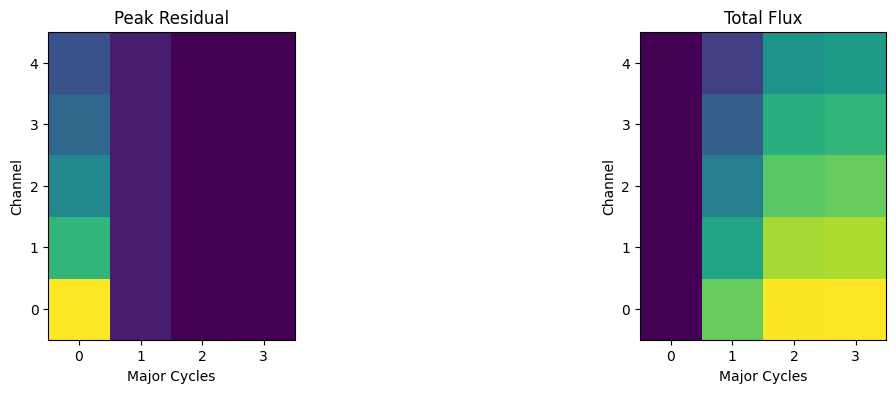

In [ ]:
chan=0
pol=0

fig=pl.figure(figsize=(14,4))
pl.clf()
ax1 = pl.subplot(121)
pl.title('Peak Residual')
ax2 = pl.subplot(122)
pl.title('Total Flux')

mat_res=pl.zeros((len(summ_minor[0].keys()),(len(summ_minor[0][0][0]['iterDone'])+1)))  ## Shape : nchan x nmajor+1
mat_flux=pl.zeros((len(summ_minor[0].keys()),(len(summ_minor[0][0][0]['iterDone'])+1)))  ## Shape : nchan x nmajor+1

# Plot for the first stokes plane only
for chan in summ_minor[0].keys():

    mat_res[chan,0] = summ_minor[0][chan][0]['startPeakRes'][0]
    mat_flux[chan,0] = summ_minor[0][chan][0]['startModelFlux'][0]

    mat_res[chan,1:] = summ_minor[0][chan][0]['peakRes']
    mat_flux[chan,1:] = summ_minor[0][chan][0]['modelFlux']
        
ax1.imshow(mat_res,origin='lower')
ax1.set_xlabel('Major Cycles');
ax1.set_ylabel('Channel');

ax2.imshow(mat_flux,origin='lower')
ax2.set_xlabel('Major Cycles');
ax2.set_ylabel('Channel');


In this example, the Peak Residual raster shows that the initial peak residual is different for all channels, but that after the first set of minor cycle iterations, the peak is the same across channels. This is because all channels stopped on 'cyclethreshold', and then consistently reduced in subsequent iterations. 

The Total Flux raster shows that the initial (start) model was zero for all channels, and that the flux built up over time, with the first channel being the brightest. 

Note that this example has extended emission, and the 'peak res' is the value of the brightest pixel, whereas the model flux represents the sum across all image pixels within the deconvolution mask. 

The 2D matrix assembled for this example may be used to generate line plots of spectra, per major cycle, if needed. 